## Experiment 3 - 1m - No Context model

In [1]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json

2024-04-30 18:25:19.987894: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 18:25:20.105609: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-30 18:25:20.595730: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/baran-tomik/bin/miniconda3/envs/tf/lib/
2024-04-30 18:25:20.595831: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvin

In [2]:
checkpoint_model_filepath = 'checkpoints/'
trained_model_filepath = 'trained_models/'
training_data_path = 'data_1m/'
nn_config_path = '../config/nn_config.json'
wandb_config_path = '../config/wandb_config.json'

print('Training data path:', training_data_path)

import nn_model

Training data path: data_1m/


/home/baran-tomik/bin/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/home/baran-tomik/bin/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bu

In [3]:
try:
  with open(wandb_config_path, 'r') as f:
    wandb_config = json.load(f)

  wandb_log = True
  wandb_run_name = wandb_config["wandb_run_name"]
  wandb_group_name = wandb_config["wandb_group_name"]
  wandb_entity = wandb_config["wandb_entity"]
  wandb_project_name = wandb_config["wandb_project_name"]
  if wandb_config["new_model"] == 'false':
    new_model = False
  else:
    new_model = True
  run_name_before = wandb_config["run_name_before"]   # Model to be loaded
  if wandb_config["eval_only"] == 'false':
    eval_only = False
  else:
    eval_only = True

  print('wandb_log:', wandb_log)
  print('wandb_run_name:', wandb_run_name)
  print('wandb_group_name:', wandb_group_name)
  print('wandb_entity:', wandb_entity)
  print('wandb_project_name:', wandb_project_name)
  print('new_model:', new_model)
  print('run_name_before:', run_name_before)
  print('eval_only:', eval_only)

except OSError as e:
  print('\nERROR loading wandb_config file')
  print(e)
  # quit()

wandb_log: True
wandb_run_name: arch5_1m_no_context_max_abs_scaler_gc_3
wandb_group_name: 1m_deep_dense
wandb_entity: xbarantomik
wandb_project_name: DP
new_model: True
run_name_before: -
eval_only: False


In [4]:
try:
  with open(nn_config_path, 'r') as f:
    nn_config = json.load(f)

  epochs = int(nn_config['epochs'])
  batch_size = int(nn_config['batch_size'])
  patience = int(nn_config['patience'])
  learning_rate = float(nn_config['learning_rate'])
  architecture = int(nn_config['architecture'])
  training_data_file = nn_config['training_data_file'] + '/'

  print('epochs:', epochs)
  print('batch_size:', batch_size)
  print('patience:', patience)
  print('learning_rate:', learning_rate)
  print('architecture:', architecture)
  print('training_data_file:', training_data_file)

except OSError as e:
  print('\nERROR loading nn_config file')
  print(e)

epochs: 25
batch_size: 128
patience: 15
learning_rate: 0.001
architecture: 5
training_data_file: no_context_max_abs_scaler/


#### Load training data

In [5]:
try:
  train_data = np.load(training_data_path + training_data_file + 'train_data.npy')
  val_data = np.load(training_data_path + training_data_file + 'val_data.npy')
  test_data = np.load(training_data_path + training_data_file + 'test_data.npy')
  train_target_ratings = np.load(training_data_path + training_data_file + 'train_target_ratings.npy')
  val_target_ratings = np.load(training_data_path + training_data_file + 'val_target_ratings.npy')
  test_target_ratings = np.load(training_data_path + training_data_file + 'test_target_ratings.npy')

except OSError as e:
  print('\nERROR loading training data')
  print(e)
  quit()

In [6]:
if wandb_log:
  import wandb
  from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

  wandb.login()

  wandb.init(
    config=nn_config,
    entity=wandb_entity,
    project=wandb_project_name,
    name=wandb_run_name,
    group=wandb_group_name
  )

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: xbarantomik. Use `wandb login --relogin` to force relogin


#### NN MODEL

In [7]:
early_stopping = EarlyStopping(patience=patience, monitor='val_loss')

In [8]:
checkpoint_filepath = checkpoint_model_filepath + f"{wandb_run_name}_checkpoint.h5"
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', save_best_only=True, mode='min', save_weights_only=False, save_format='tf')

if wandb_log:
  callbacks = [early_stopping, checkpoint_callback, WandbMetricsLogger()]
else:
  callbacks = [early_stopping, checkpoint_callback]

#### Create model

In [9]:
if new_model:
  my_model = nn_model.create_model(architecture=architecture, lr=learning_rate, train_data_shape=train_data.shape[1])
  print('\nCreated a new model')
else:
  my_model = load_model(checkpoint_model_filepath + run_name_before + '_checkpoint.h5')
  print('\nLoaded a model')

if my_model != None:
  my_model.summary()
else:
  print('\nERROR loading NN model')
  quit()

Model 5

Created a new model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               1536      
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         


2024-04-30 18:25:27.321788: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-30 18:25:27.346794: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-30 18:25:27.346963: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-30 18:25:27.347488: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 activation_2 (Activation)   (None, 512)               0         
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (

## Model fitting

In [10]:
if not eval_only:
  print('Training model')
  trained_model = my_model.fit(train_data, train_target_ratings, batch_size, epochs, validation_data=(val_data, val_target_ratings), callbacks=callbacks, verbose=1)
  my_model.save(trained_model_filepath + f"{wandb_run_name}_trained.keras")
else:
  print('Only evaluating model')

Training model
Epoch 1/25
6252/6252 [==============================] - 16s 2ms/step - loss: 1.2792 - root_mean_squared_error: 1.1310 - mean_absolute_error: 0.9279 - r_square: -0.0263 - val_loss: 1.2209 - val_root_mean_squared_error: 1.1050 - val_mean_absolute_error: 0.9153 - val_r_square: 0.0277
Epoch 2/25
6252/6252 [==============================] - 15s 2ms/step - loss: 1.2323 - root_mean_squared_error: 1.1101 - mean_absolute_error: 0.9160 - r_square: 0.0114 - val_loss: 1.2315 - val_root_mean_squared_error: 1.1097 - val_mean_absolute_error: 0.9309 - val_r_square: 0.0194
Epoch 3/25
6252/6252 [==============================] - 15s 2ms/step - loss: 1.2273 - root_mean_squared_error: 1.1078 - mean_absolute_error: 0.9149 - r_square: 0.0154 - val_loss: 1.2162 - val_root_mean_squared_error: 1.1028 - val_mean_absolute_error: 0.9145 - val_r_square: 0.0315
Epoch 4/25
6252/6252 [==============================] - 15s 2ms/step - loss: 1.2231 - root_mean_squared_error: 1.1059 - mean_absolute_error: 

#### After fitting


----------- Loss chart -----------



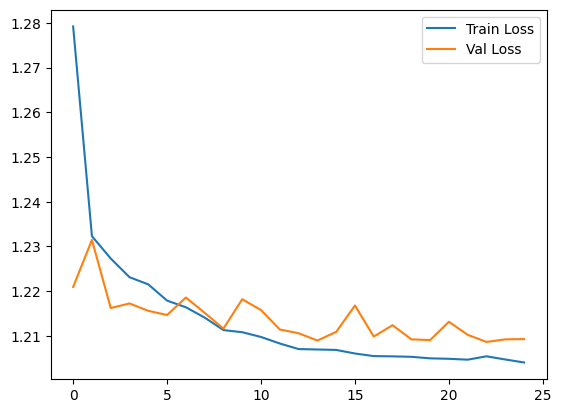


----------- RootMSE chart -----------



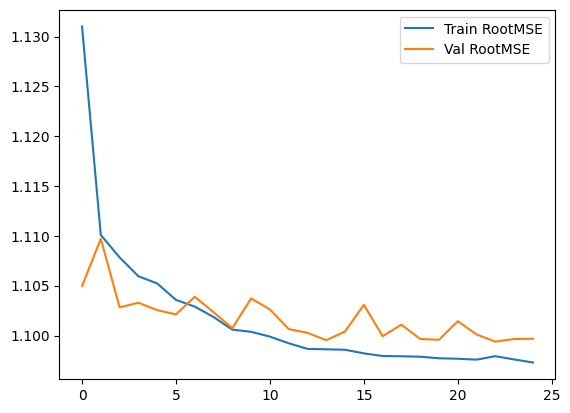


----------- MAE chart -----------



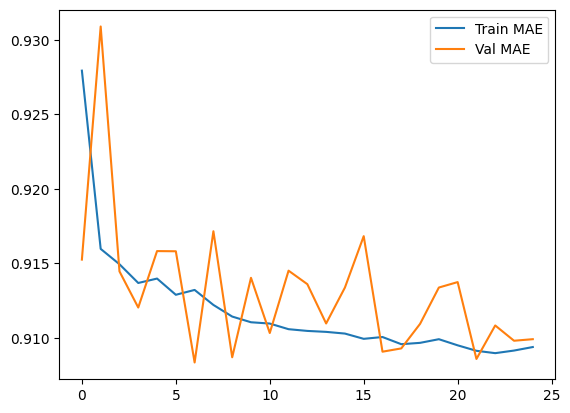


----------- R2 chart -----------



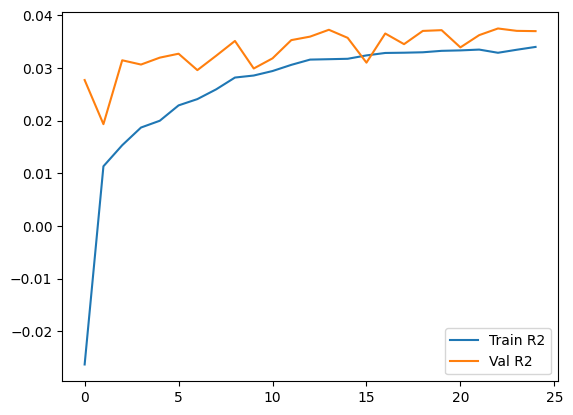

In [11]:
metric_name = ['Loss', 'RootMSE', 'MAE', 'R2']
train_metric = ['loss', 'root_mean_squared_error', 'mean_absolute_error', 'r_square']
val_metric = ['val_loss', 'val_root_mean_squared_error', 'val_mean_absolute_error', 'val_r_square']

for i in range(len(metric_name)):

  print(f"\n----------- {metric_name[i]} chart -----------\n")

  # matplotlib chart
  plt.plot(trained_model.history[train_metric[i]], label=f"Train {metric_name[i]}")
  plt.plot(trained_model.history[val_metric[i]], label=f"Val {metric_name[i]}")
  plt.legend()
  plt.show()

In [12]:
# Validation data values in the last epoch
print("number of epochs:", trained_model.epoch[-1] + 1)
print("val_loss:", trained_model.history['val_loss'][-1])
print("val_root_mean_squared_error:", trained_model.history['val_root_mean_squared_error'][-1])
print("val_mean_absolute_error:", trained_model.history['val_mean_absolute_error'][-1])
print("val_r2_score:", trained_model.history['val_r_square'][-1])

number of epochs: 25
val_loss: 1.2092845439910889
val_root_mean_squared_error: 1.0996747016906738
val_mean_absolute_error: 0.9099159240722656
val_r2_score: 0.03700798749923706


In [13]:
# Evaluate the model on the test data
print("Evaluate on test data")
test_loss, test_mean_squared_error, test_mean_absolute_error, test_r2_score = my_model.evaluate(test_data, test_target_ratings)
print("Test_loss:", test_loss)
print("Test_root_mean_squared_error:", test_mean_squared_error)
print("Test_mean_absolute_error:", test_mean_absolute_error)
print("Test_r2_score:", test_r2_score)
print('\n')

print("Generate predictions for 10 samples")
predictions = my_model.predict(test_data)
test_y_comparison = pd.DataFrame({'test_y_true': test_target_ratings, 'test_y_pred': [x for x in predictions]})

print(test_y_comparison.head(10))

Evaluate on test data
3126/3126 [==============================] - 4s 1ms/step - loss: 1.2100 - root_mean_squared_error: 1.1000 - mean_absolute_error: 0.9110 - r_square: 0.0334
Test_loss: 1.209986686706543
Test_root_mean_squared_error: 1.0999939441680908
Test_mean_absolute_error: 0.9109877347946167
Test_r2_score: 0.03342252969741821


Generate predictions for 10 samples
3126/3126 [==============================] - 2s 746us/step
   test_y_true  test_y_pred
0            4  [3.4432838]
1            3  [3.4322362]
2            5  [3.4848673]
3            5  [3.5327933]
4            4  [3.5330048]
5            4  [3.4500978]
6            4  [3.5152342]
7            3   [4.060899]
8            1    [3.53937]
9            5  [4.0257473]


In [14]:
if wandb_log:
  wandb.finish()

epoch/epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/mean_absolute_error,█▄▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch/r_square,▁▅▆▆▆▇▇▇▇▇▇██████████████
epoch/root_mean_squared_error,█▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,▅█▃▄▃▃▄▃▂▄▃▂▂▁▂▃▁▂▁▁▂▁▁▁▁
epoch/val_mean_absolute_error,▃█▃▂▃▃▁▄▁▃▂▃▃▂▃▄▁▁▂▃▃▁▂▁▁
epoch/val_r_square,▄▁▆▅▆▆▅▆▇▅▆▇▇█▇▆█▇██▇████
epoch/val_root_mean_squared_error,▅█▃▄▃▃▄▃▂▄▃▂▂▁▂▄▁▂▁▁▂▁▁▁▁
epoch/epoch,24


: 